In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('^HSI','2020-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_14456/4010771603.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2020-01-02,28249.369141,28543.519531,28245.970703,28543.519531,28543.519531,28451.500000
2020-01-03,28828.359375,28883.300781,28428.169922,28451.500000,28451.500000,28226.189453
2020-01-06,28326.500000,28367.869141,28054.289062,28226.189453,28226.189453,28322.060547
2020-01-07,28352.679688,28473.080078,28264.070312,28322.060547,28322.060547,28087.919922
2020-01-08,27999.580078,28198.609375,27857.730469,28087.919922,28087.919922,28561.000000
...,...,...,...,...,...,...
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.539062


In [3]:
data_val=data[-100:]
data=data[:-100]

In [4]:
sc = StandardScaler()
sc_y= MinMaxScaler(feature_range = (0, 1))

In [5]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(315, 1, 5) (315,) (79, 1, 5) (79,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_14456/3471942301.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [6]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(
    units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-10 20:19:47.100222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 20:19:47.100338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=700,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/700


2022-04-10 20:19:47.523548: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 20:19:48.777675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:19:48.980226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:19:49.018276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:19:49.093617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:19:49.155713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 68ms/step - loss: 668592384.0000 - val_loss: 834499840.0000
Epoch 2/700
 7/18 [==========>...................] - ETA: 0s - loss: 646829696.0000

2022-04-10 20:19:50.240137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:19:50.312895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:19:50.334135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 11ms/step - loss: 668570688.0000 - val_loss: 834483840.0000
Epoch 3/700
18/18 [==============================] - 0s 11ms/step - loss: 668510912.0000 - val_loss: 834471104.0000
Epoch 4/700
18/18 [==============================] - 0s 10ms/step - loss: 668272064.0000 - val_loss: 834493312.0000
Epoch 5/700
18/18 [==============================] - 0s 10ms/step - loss: 667471744.0000 - val_loss: 834560064.0000
Epoch 6/700
18/18 [==============================] - 0s 10ms/step - loss: 665975744.0000 - val_loss: 834571072.0000
Epoch 7/700
18/18 [==============================] - 0s 10ms/step - loss: 664191552.0000 - val_loss: 834455040.0000
Epoch 8/700
18/18 [==============================] - 0s 10ms/step - loss: 662278720.0000 - val_loss: 834129536.0000
Epoch 9/700
18/18 [==============================] - 0s 11ms/step - loss: 660133184.0000 - val_loss: 833303936.0000
Epoch 10/700
18/18 [==============================] - 0s 11ms/step - loss: 657583104

18/18 [==============================] - 0s 10ms/step - loss: 198369824.0000 - val_loss: 286572736.0000
Epoch 73/700
18/18 [==============================] - 0s 10ms/step - loss: 191536032.0000 - val_loss: 278273056.0000
Epoch 74/700
18/18 [==============================] - 0s 10ms/step - loss: 184825296.0000 - val_loss: 270098240.0000
Epoch 75/700
18/18 [==============================] - 0s 10ms/step - loss: 178240224.0000 - val_loss: 262051632.0000
Epoch 76/700
18/18 [==============================] - 0s 10ms/step - loss: 171783200.0000 - val_loss: 254136064.0000
Epoch 77/700
18/18 [==============================] - 0s 11ms/step - loss: 165456448.0000 - val_loss: 246354208.0000
Epoch 78/700
18/18 [==============================] - 0s 10ms/step - loss: 159261968.0000 - val_loss: 238708672.0000
Epoch 79/700
18/18 [==============================] - 0s 10ms/step - loss: 153201584.0000 - val_loss: 231201728.0000
Epoch 80/700
18/18 [==============================] - 0s 10ms/step - loss: 14

18/18 [==============================] - 0s 11ms/step - loss: 5603624.5000 - val_loss: 19869334.0000
Epoch 143/700
18/18 [==============================] - 0s 10ms/step - loss: 5412782.5000 - val_loss: 19249206.0000
Epoch 144/700
18/18 [==============================] - 0s 10ms/step - loss: 5239235.5000 - val_loss: 18662982.0000
Epoch 145/700
18/18 [==============================] - 0s 10ms/step - loss: 5081664.0000 - val_loss: 18108984.0000
Epoch 146/700
18/18 [==============================] - 0s 10ms/step - loss: 4938823.0000 - val_loss: 17585610.0000
Epoch 147/700
18/18 [==============================] - 0s 10ms/step - loss: 4809544.0000 - val_loss: 17091320.0000
Epoch 148/700
18/18 [==============================] - 0s 10ms/step - loss: 4692731.5000 - val_loss: 16624652.0000
Epoch 149/700
18/18 [==============================] - 0s 10ms/step - loss: 4587357.5000 - val_loss: 16184184.0000
Epoch 150/700
18/18 [==============================] - 0s 10ms/step - loss: 4492461.5000 - val

18/18 [==============================] - 0s 10ms/step - loss: 3773853.0000 - val_loss: 9468644.0000
Epoch 214/700
18/18 [==============================] - 0s 10ms/step - loss: 3774075.0000 - val_loss: 9464564.0000
Epoch 215/700
18/18 [==============================] - 0s 11ms/step - loss: 3774282.0000 - val_loss: 9460848.0000
Epoch 216/700
18/18 [==============================] - 0s 13ms/step - loss: 3774469.0000 - val_loss: 9457466.0000
Epoch 217/700
18/18 [==============================] - 0s 12ms/step - loss: 3774637.0000 - val_loss: 9454397.0000
Epoch 218/700
18/18 [==============================] - 0s 10ms/step - loss: 3774778.2500 - val_loss: 9451604.0000
Epoch 219/700
18/18 [==============================] - 0s 11ms/step - loss: 3774888.2500 - val_loss: 9449068.0000
Epoch 220/700
18/18 [==============================] - 0s 10ms/step - loss: 3774950.7500 - val_loss: 9446752.0000
Epoch 221/700
18/18 [==============================] - 0s 10ms/step - loss: 3774941.7500 - val_loss: 9

18/18 [==============================] - 0s 10ms/step - loss: 295613.0000 - val_loss: 827972.3125
Epoch 286/700
18/18 [==============================] - 0s 10ms/step - loss: 287023.6875 - val_loss: 788874.6250
Epoch 287/700
18/18 [==============================] - 0s 11ms/step - loss: 278819.9375 - val_loss: 751809.2500
Epoch 288/700
18/18 [==============================] - 0s 10ms/step - loss: 270978.5000 - val_loss: 716660.3750
Epoch 289/700
18/18 [==============================] - 0s 11ms/step - loss: 263478.7812 - val_loss: 683329.3750
Epoch 290/700
18/18 [==============================] - 0s 11ms/step - loss: 256299.5625 - val_loss: 651707.8125
Epoch 291/700
18/18 [==============================] - 0s 11ms/step - loss: 249421.8594 - val_loss: 621701.3750
Epoch 292/700
18/18 [==============================] - 0s 12ms/step - loss: 242826.7969 - val_loss: 593213.7500
Epoch 293/700
18/18 [==============================] - 0s 11ms/step - loss: 236496.9688 - val_loss: 566164.8750
Epoch 

18/18 [==============================] - 0s 12ms/step - loss: 58070.4688 - val_loss: 76430.3594
Epoch 359/700
18/18 [==============================] - 0s 12ms/step - loss: 57043.0664 - val_loss: 75516.3750
Epoch 360/700
18/18 [==============================] - 0s 11ms/step - loss: 56035.1602 - val_loss: 74637.3281
Epoch 361/700
18/18 [==============================] - 0s 11ms/step - loss: 55046.5859 - val_loss: 73789.9531
Epoch 362/700
18/18 [==============================] - 0s 11ms/step - loss: 54076.4180 - val_loss: 72973.0938
Epoch 363/700
18/18 [==============================] - 0s 11ms/step - loss: 53124.8633 - val_loss: 72183.6250
Epoch 364/700
18/18 [==============================] - 0s 12ms/step - loss: 52191.9492 - val_loss: 71418.7812
Epoch 365/700
18/18 [==============================] - 0s 11ms/step - loss: 51277.6523 - val_loss: 70677.9219
Epoch 366/700
18/18 [==============================] - 0s 11ms/step - loss: 50382.4023 - val_loss: 69957.5625
Epoch 367/700
18/18 [===

18/18 [==============================] - 0s 11ms/step - loss: 18582.5859 - val_loss: 33121.8359
Epoch 433/700
18/18 [==============================] - 0s 11ms/step - loss: 18347.4238 - val_loss: 32659.7969
Epoch 434/700
18/18 [==============================] - 0s 11ms/step - loss: 18116.4375 - val_loss: 32204.7812
Epoch 435/700
18/18 [==============================] - 0s 11ms/step - loss: 17889.7715 - val_loss: 31752.9199
Epoch 436/700
18/18 [==============================] - 0s 10ms/step - loss: 17667.1035 - val_loss: 31306.9570
Epoch 437/700
18/18 [==============================] - 0s 10ms/step - loss: 17448.4883 - val_loss: 30864.6230
Epoch 438/700
18/18 [==============================] - 0s 11ms/step - loss: 17233.5742 - val_loss: 30429.2598
Epoch 439/700
18/18 [==============================] - 0s 11ms/step - loss: 17022.5156 - val_loss: 29996.3359
Epoch 440/700
18/18 [==============================] - 0s 11ms/step - loss: 16814.9219 - val_loss: 29571.0918
Epoch 441/700
18/18 [===

Epoch 507/700
18/18 [==============================] - 0s 12ms/step - loss: 7561.3940 - val_loss: 9975.6484
Epoch 508/700
18/18 [==============================] - 0s 11ms/step - loss: 7456.7935 - val_loss: 12203.4404
Epoch 509/700
18/18 [==============================] - 0s 12ms/step - loss: 7549.0674 - val_loss: 8860.0029
Epoch 510/700
18/18 [==============================] - 0s 12ms/step - loss: 7670.2261 - val_loss: 14997.3145
Epoch 511/700
18/18 [==============================] - 0s 11ms/step - loss: 8422.4941 - val_loss: 8021.6963
Epoch 512/700
18/18 [==============================] - 0s 12ms/step - loss: 10125.5879 - val_loss: 28445.3145
Epoch 513/700
18/18 [==============================] - 0s 12ms/step - loss: 14147.4785 - val_loss: 14248.9551
Epoch 514/700
18/18 [==============================] - 0s 12ms/step - loss: 21954.9434 - val_loss: 90722.3516
Epoch 515/700
18/18 [==============================] - 0s 14ms/step - loss: 28631.2773 - val_loss: 36495.7188
Epoch 516/700
18/1

18/18 [==============================] - 0s 12ms/step - loss: 8936.7500 - val_loss: 5717.4507
Epoch 583/700
18/18 [==============================] - 0s 12ms/step - loss: 6324.3818 - val_loss: 6832.0273
Epoch 584/700
18/18 [==============================] - 0s 12ms/step - loss: 6276.1265 - val_loss: 5970.4336
Epoch 585/700
18/18 [==============================] - 0s 12ms/step - loss: 6106.3403 - val_loss: 12351.1953
Epoch 586/700
18/18 [==============================] - 0s 13ms/step - loss: 5886.4175 - val_loss: 8468.0225
Epoch 587/700
18/18 [==============================] - 0s 14ms/step - loss: 6698.5591 - val_loss: 17125.8906
Epoch 588/700
18/18 [==============================] - 0s 12ms/step - loss: 6993.0298 - val_loss: 9044.5098
Epoch 589/700
18/18 [==============================] - 0s 10ms/step - loss: 7848.5796 - val_loss: 15026.5400
Epoch 590/700
18/18 [==============================] - 0s 10ms/step - loss: 9233.3359 - val_loss: 6278.3008
Epoch 591/700
18/18 [==================

18/18 [==============================] - 0s 10ms/step - loss: 21959.3438 - val_loss: 3491.2788
Epoch 658/700
18/18 [==============================] - 0s 10ms/step - loss: 6937.7573 - val_loss: 5405.1240
Epoch 659/700
18/18 [==============================] - 0s 14ms/step - loss: 4500.1860 - val_loss: 7776.0088
Epoch 660/700
18/18 [==============================] - 0s 11ms/step - loss: 6562.9868 - val_loss: 16340.6777
Epoch 661/700
18/18 [==============================] - 0s 11ms/step - loss: 7126.8535 - val_loss: 10839.9766
Epoch 662/700
18/18 [==============================] - 0s 11ms/step - loss: 8206.8262 - val_loss: 12667.2520
Epoch 663/700
18/18 [==============================] - 0s 10ms/step - loss: 13524.3623 - val_loss: 3700.1179
Epoch 664/700
18/18 [==============================] - 0s 10ms/step - loss: 24082.8633 - val_loss: 3365.8296
Epoch 665/700
18/18 [==============================] - 0s 12ms/step - loss: 7788.4214 - val_loss: 4995.2466
Epoch 666/700
18/18 [===============

2022-04-10 20:22:10.541760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:22:10.617782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 20:22:10.647654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


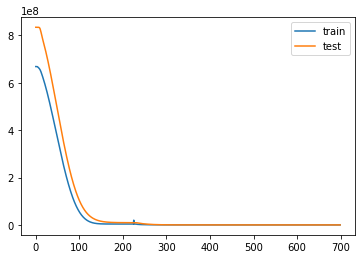

In [8]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

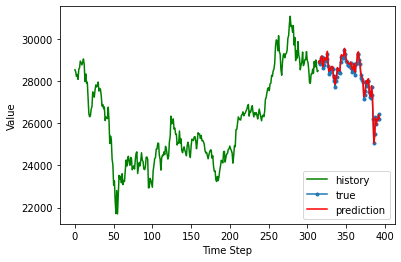

In [9]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

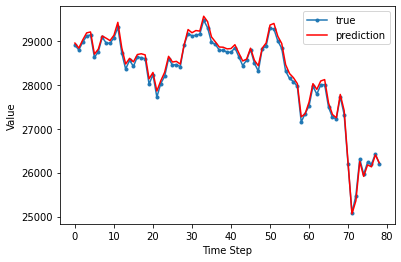

In [10]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [11]:
r2_score(y_test,y_pred)

0.9928610637038593

In [12]:
mean_absolute_percentage_error(y_test,y_pred)

0.0026523762941916243

In [13]:
mean_squared_error(y_test,y_pred,squared=False)

82.01651266474718

In [14]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_14456/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


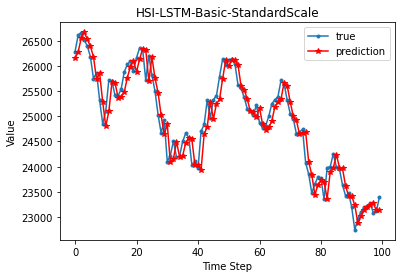

In [19]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-Basic-StandardScale')
plt.legend()
plt.show()

In [16]:
r2_score(y_val,y_val_pred)

0.9145295454959775

In [17]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.009414571172759744

In [18]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

293.6824479048843